### Import libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import random
import json
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import re
from bertopic import BERTopic
from umap import UMAP

# Introduction

In this project, I set out to explore various NLP methodologies, applying them to a dataset of the collected works of 5 artists and seeing which trends they could pick up. Unfortunately, most of the more sophisticated NLP methodologies I wanted to explore proved unfruitful. While I made efforts to use cutting-edge libraries like Bertopic to do word frequency analysis, sentiment analysis, and topic modeling, tuning them with different preprocessing methods and stopword dictionaries for hours, these methods were simply unable to provide any useful information. Part of this was because of the limited size of the dataset I was working with (around 100,000 words total per artist). Another issue was that the songs are simply too varied in style and subject matter, even for a given artist, for the algorithms to pick up on any obvious trends. These algorithms can really only perform effectively when given a huge corpus of text which focuses in on a few topics -- i.e. political speeches or product reviews. 

In the end, I was still able to pick out a couple of simple metrics which actually told an effective story for each artist: average number of syllables per word, and average number of words per song. The former metric gives a good heuristic for linguistic complexity (the industry standard Flesch-Kincaid score could be used for song lyrics since it depends upon sentence length, and my lyrics information did not have punction). The latter metric tells us more about the narrative in the song, with a thousand-word-song being much more likely to have a long, structured narrative with complex themes than a two-hundred-word song.

# Scraping lyrics
Libraries:

I used requests to make HTTP requests to web pages and BeautifulSoup to parse and extract the HTML data from each song page.

Data storage:

I write each song to a json file with the song's information stored as a dictionary. When you run the code,it runs through every song, skippping those that have been scraped and are already present in my database. This way, we can dynamically pause and resume the code, rather than having to download it all in one go. This code should not scrape any songs if all of the songs are already present (which should be the case, if you have downloaded the entire folder, which contains the full json files).

Interruptions:

Azlyrics kept detecting that I was using a robot and banning me. I experimented with random delays in between scraping each page, even making it as high as 25 seconds - 1 minute, but the website still detected it after a while. I ended up using a more complex distribution of times, where every so often it pauses for a __very__ long time -- 15 minutes to 30 minutes. This emulates human behavior and seemed to trick the site.


In [2]:


# Define the file paths to save data
paths = ["bobdylan_songs.json", "steviewonder_songs.json", "police_songs.json", "taylorswift_songs.json", "jonimitchell_songs.json", "sting_songs.json"]
urls = ["https://www.azlyrics.com/d/dylan.html","https://www.azlyrics.com/w/wonder.html", "https://www.azlyrics.com/p/police.html", "https://www.azlyrics.com/t/taylorswift.html", "https://www.azlyrics.com/j/jonimitchell.html", "https://www.azlyrics.com/s/sting.html"]

for i in range(len(paths)):
    save_file_path = paths[i]

    # Load previously saved data (if any)
    if os.path.exists(save_file_path):
        with open(save_file_path, "r") as file:
            songs = json.load(file)
    else:
        songs = []

    # Get list of previously scraped song titles (to avoid duplicates)
    scraped_song_titles = {song["song_title"] for song in songs}

    # URL of the artist page on AZLyrics
    url = urls[i]
    html = requests.get(url).text
    soup = BeautifulSoup(html, "html.parser")
    #print(soup)
    # Find the parent div that contains albums and songs
    parent_div = soup.find('div', id='listAlbum')
    child_divs = parent_div.select('div')

    # Variables to store album info
    album_format, album_title, year = None, None, None

    # Iterate over the child divs to find album and song info
    for div in child_divs:
        # Check for album elements
        if div.get('class') == ["album"]:
            # Get album format and title
            temp = div.text.split(":", 1)
            album_format = temp[0]
            title_div = div.find("b")
            album_title = title_div.text.replace('"', "")

            # Get year (if available)
            other_info = title_div.find_next(string=True).find_next(string=True)
            year = "".join([char for char in other_info if char.isdigit()])
            if year:
                year = int(year)

        # Check for song elements
        elif div.get('class') == ["listalbum-item"]:
            song_title = div.text.strip()

            # Skip the song if it has already been scraped
            if song_title in scraped_song_titles:
                continue

            a_tag = div.find("a")
            if a_tag and a_tag.get("href"):
                # add the azlyrics prefix if it does not already exist
                song_link = a_tag.get("href")
                if song_link[:5] != "https":
                    song_link = "https://www.azlyrics.com" + song_link
            else: 
                continue

            # Wait a random time to avoid detection
            wait_time = random.uniform(15, 60)
            if random.randint(0,19) == 0:
                wait_time = random.uniform(600,1800)
            print(f"Waiting for {wait_time:.2f} seconds before scraping {song_title}...")
            time.sleep(wait_time)

            # Scrape the song lyrics
            song_lyrics_html = requests.get(song_link).text
            song_lyrics_soup = BeautifulSoup(song_lyrics_html, "html.parser")

            # Find the lyrics 
            lyrics_element = song_lyrics_soup.select('br')[0].next_sibling.next_sibling.next_sibling.next_sibling
            while lyrics_element.text == "\n" or lyrics_element.text == "":
                lyrics_element = lyrics_element.next_sibling
            lyrics = lyrics_element.text

            # Find the writers, if they are noted
            smalls = song_lyrics_soup.select('small')
            writers_elements = [small.text for small in smalls if "Writer(s)" in small.text]
            if len(writers_elements) > 0:
                writers = writers_elements[0].split(": ")[1].split(", ")
            else:
                writers = None

            # Add the song data to the list
            song_data = {
                "album_format": album_format,
                "album_title": album_title,
                "year": year,
                "song_title": song_title,
                "song_link": song_link,
                "lyrics": lyrics,
                "writers": writers
            }
            songs.append(song_data)
            scraped_song_titles.add(song_title)

            # Save the progress to file after each song is scraped
            with open(save_file_path, "w") as file:
                json.dump(songs, file, indent=4)

            print(f"Scraped: {song_title}")

    print(f"Scraping for {paths[i]} complete!")

Scraping for bobdylan_songs.json complete!
Scraping for steviewonder_songs.json complete!
Scraping for police_songs.json complete!
Scraping for taylorswift_songs.json complete!
Scraping for jonimitchell_songs.json complete!
Scraping for sting_songs.json complete!


# Data cleaning
I created two versions of the lyrics, a normal cleaned lyrics column and a pre-processed lyrics column which has stopwords removed.

In [3]:
def basic_clean(df):
    # Convert line breaks to spaces in the 'lyrics' column
    df['lyrics'] = df['lyrics'].apply(lambda text: text.replace('\n', ' ').replace('\r', ' ').strip())
    
    # Drop rows where 'album_format' is 'other songs'
    df.drop(df[df['album_format'] == 'other songs'].index, inplace=True)

    # Convert 'year' to int, coerce errors to NaN, then fill NaN with a specific value if needed (e.g., 0)
    df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)

    # Function to preprocess lyrics
    def preprocess_lyrics(lyrics):
        lyrics = lyrics.lower()
        # Remove non-alphabetic characters and extra whitespaces
        lyrics = re.sub(r'[^a-z\s]', '', lyrics)
        # Tokenize and remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in lyrics.split() if word not in stop_words]
        return ' '.join(tokens)

    # Apply preprocessing to all lyrics in the dataframe
    df['processed_lyrics'] = df['lyrics'].apply(preprocess_lyrics)
    return df  # Return the cleaned DataFrame

# Helper functions
mean_by_year is a "function of functions". Given a dataset and a function, it will graph the mean value of that function by year. Then I define the helper functions to get #syllables per word and average song length.

In [20]:
import pyphen
nltk.download('punkt')
from adjustText import adjust_text

def mean_by_year(df, function, processed=False):
    if processed == True:
        df['fn_value'] = df['processed_lyrics'].apply(function)
    else:
        df['fn_value'] = df['lyrics'].apply(function)
    mean_fn_value = df.groupby('album_title')['fn_value'].mean().reset_index()
    mean_fn_value = mean_fn_value.merge(df[['album_title', 'year']].drop_duplicates(), on='album_title').sort_values(by='year')
    return (mean_fn_value)

def syllable_count(word):
    dic = pyphen.Pyphen(lang='en')
    hyphens = dic.inserted(word)
    return max(1, hyphens.count('-') + 1)

def syll_per_word(text):
    words = [word for word in nltk.word_tokenize(text) if word.isalpha()]  # Filter for alphabetic words
    syllables = sum(syllable_count(word) for word in words)
    if len(words) == 0: return 0
    fk_grade = syllables / len(words)
    return fk_grade

def syll_and_len_plot(df, artist):
    # Create a figure with two subplots stacked vertically
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # First plot: Average syllables per word in albums written by the artist
    data = mean_by_year(df, lambda lyric: syll_per_word(lyric), processed=True)
    sns.lineplot(data=data, x='year', y='fn_value', marker='o', ax=axes[0])

    texts_0 = []
    for i in range(len(data)):
        txt_0 = axes[0].text(data['year'][i], data['fn_value'][i], data['album_title'][i],
                    color='black', ha='left', va='bottom', fontsize=7)
        texts_0.append(txt_0)
    adjust_text(texts_0, ax=axes[0],arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

    axes[0].set_ylabel("Average # syllables per word")
    axes[0].set_title(f"Average number of syllables per word for {artist} albums")
    axes[0].grid(True)

    # Second plot: Average song length in albums written by the artist
    data = mean_by_year(df, lambda lyric: len(lyric), processed=False)
    sns.lineplot(data=data, x='year', y='fn_value', marker='o', ax=axes[1], color="red")

    texts_1 = []
    for i in range(len(data)):
        txt_1 = axes[1].text(data['year'][i], data['fn_value'][i], data['album_title'][i],
                    color='black', ha='left', va='bottom', fontsize=7)
        texts_1.append(txt_1)
    adjust_text(texts_1,ax=axes[1], arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

    axes[1].set_ylabel("Average # words per song")
    axes[1].set_title(f"Average song length of {artist} albums")
    axes[1].grid(True)


    # # Third plot: TTR
    # data = mean_by_year(df, lambda lyric: len(set(lyric)) / len(lyric), processed=True)
    # sns.lineplot(data=data, x='year', y='fn_value', marker='o', ax=axes[2], color="green")

    # texts_2 = []
    # for i in range(len(data)):
    #     txt_2 = axes[2].text(data['year'][i], data['fn_value'][i], data['album_title'][i],
    #                 color='black', ha='left', va='bottom', fontsize=7)
    #     texts_2.append(txt_2)
    # adjust_text(texts_2,ax=axes[2], arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

    # axes[2].set_ylabel("Average TTR")
    # axes[2].set_title(f"Average TTR for {artist} albums")
    # axes[2].grid(True)



    plt.tight_layout()
    plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/henryfisher/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# The results

### The Police and Sting


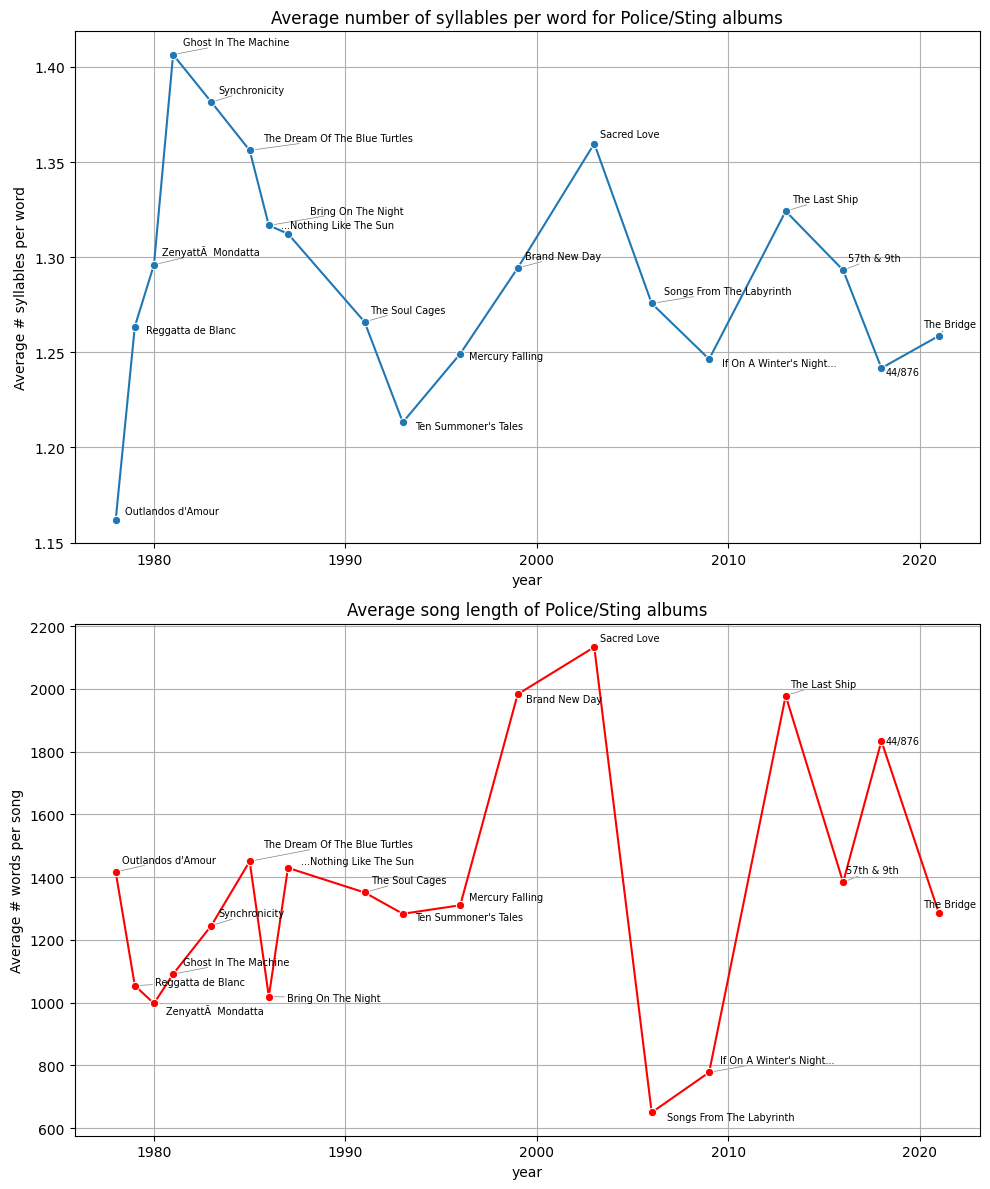

In [21]:
police_songs = pd.read_json("police_songs.json")
sting_songs = pd.read_json("sting_songs.json")
df = pd.concat([police_songs, sting_songs], ignore_index=True)
df.drop(df[df['album_title'] == "...Nada Como El Sol"].index, inplace=True)
df.drop(df[df['album_title'] == "Symphonicities"].index, inplace=True)
df = basic_clean(df)

syll_and_len_plot(df, "Police/Sting")
#axes[0].axvline(x=1984, color='red', linestyle='--', label="The Police disband")


The Police’s early work (1978-83) was often influenced by punk and reggae, with lyrics that were direct and concise (“Roxanne”, “Can't Stand Losing You”). We can see a clear trend towards increasingly complex language throughout the Police's 5-album career, a trend I predicted in my "context" essay. 

The phase of songwriting between Blue Turtles and Mercury Falling shows an equally clear downward trend in the first graph and a plateau in the second. This reflects a slow shift towards greater linguistic simplicity (contrast "Russians" with "Fields of Gold") during this period.

Sting’s later works, such as Sacred Love and The Last Ship, are less cohesive with each other, delving into broader themes and experiment with narrative complexity. We see less clear trends during this period. Some albums, like If On A Winters Night, are rooted in folk traditions, which tend to have simpler songs.

### Taylor Swift

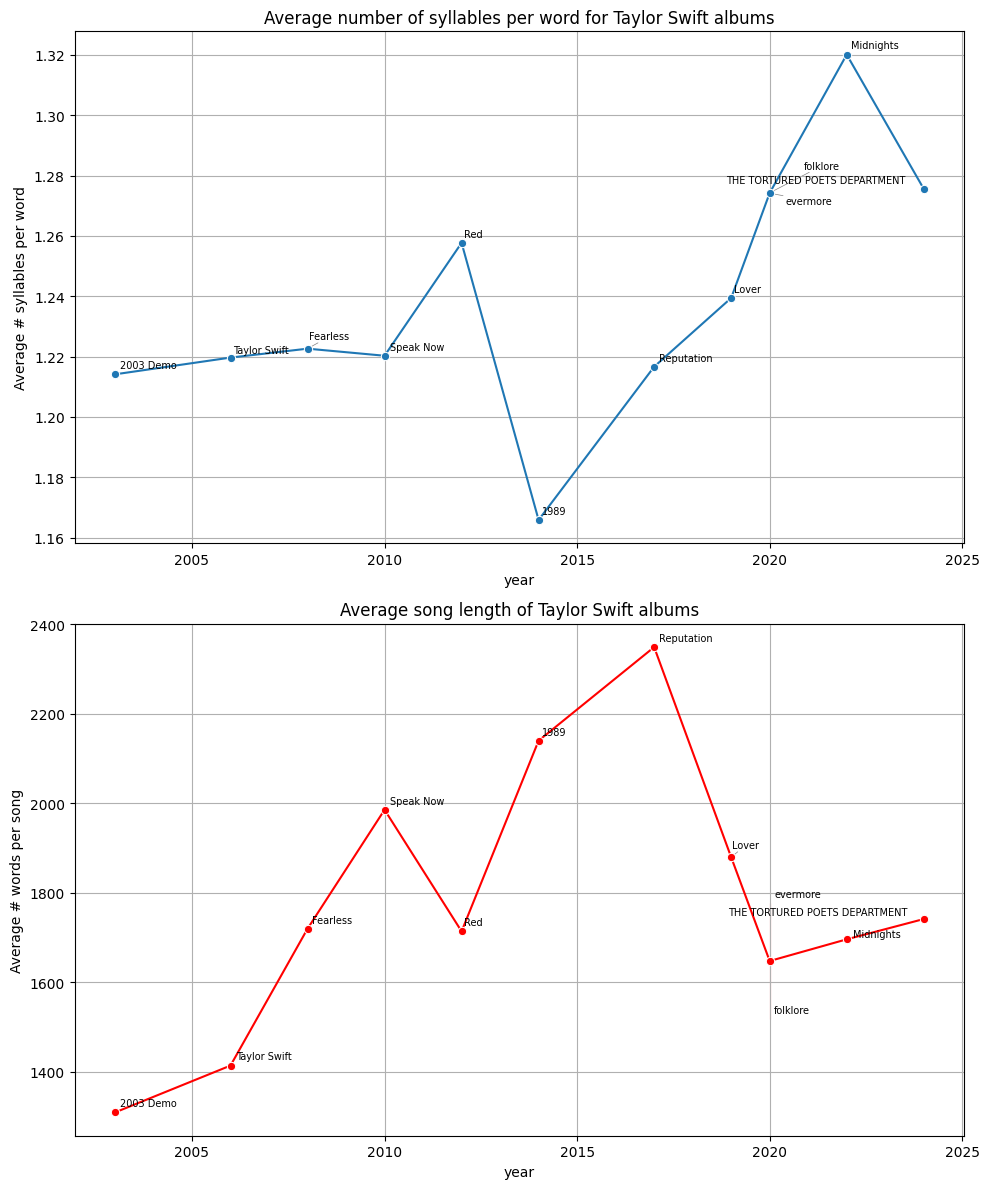

In [22]:
df = pd.read_json("taylorswift_songs.json")
df = basic_clean(df)
for title in ["Red (Taylor's Version)", "Fearless (Taylor's Version)", "Speak Now (Taylor's Version)",
              "1989 (Taylor's Version)", "Sounds Of The Season: The Taylor Swift Holiday Collection"]:
    df.drop(df[df['album_title'] == title].index, inplace=True)

syll_and_len_plot(df, "Taylor Swift")

In Taylor's early country output (2003-10), syllables/word ratio and song length are low, due to country music favoring straightforward, conversational language and simple narratives (e.g., “Love Story,” “Tim McGraw”). However, songs like “Dear John” from Speak Now showcase growing lyrical complexity.

As Taylor shifted to pop (2012-2014), song length continued to increase as narratives became longer (i.e. "All Too Well"), but syllables/word fluctuated, with 1989, Taylor's most critically acclaimed album, featuring simple, repetitive hooks like "Shake It Off": "Players gonna play play, play, play, play."

Song length peaked at Reputation, Taylor's most disliked album, and then switched direction as Taylor changed tack (I elaborate on this in my context essay). Syllables per word is highest during albums like Folklore, Evermore, and Midnights which lean into literary, highly referential songwriting (“The Last Great American Dynasty,” “Epiphany”).

## Stevie Wonder

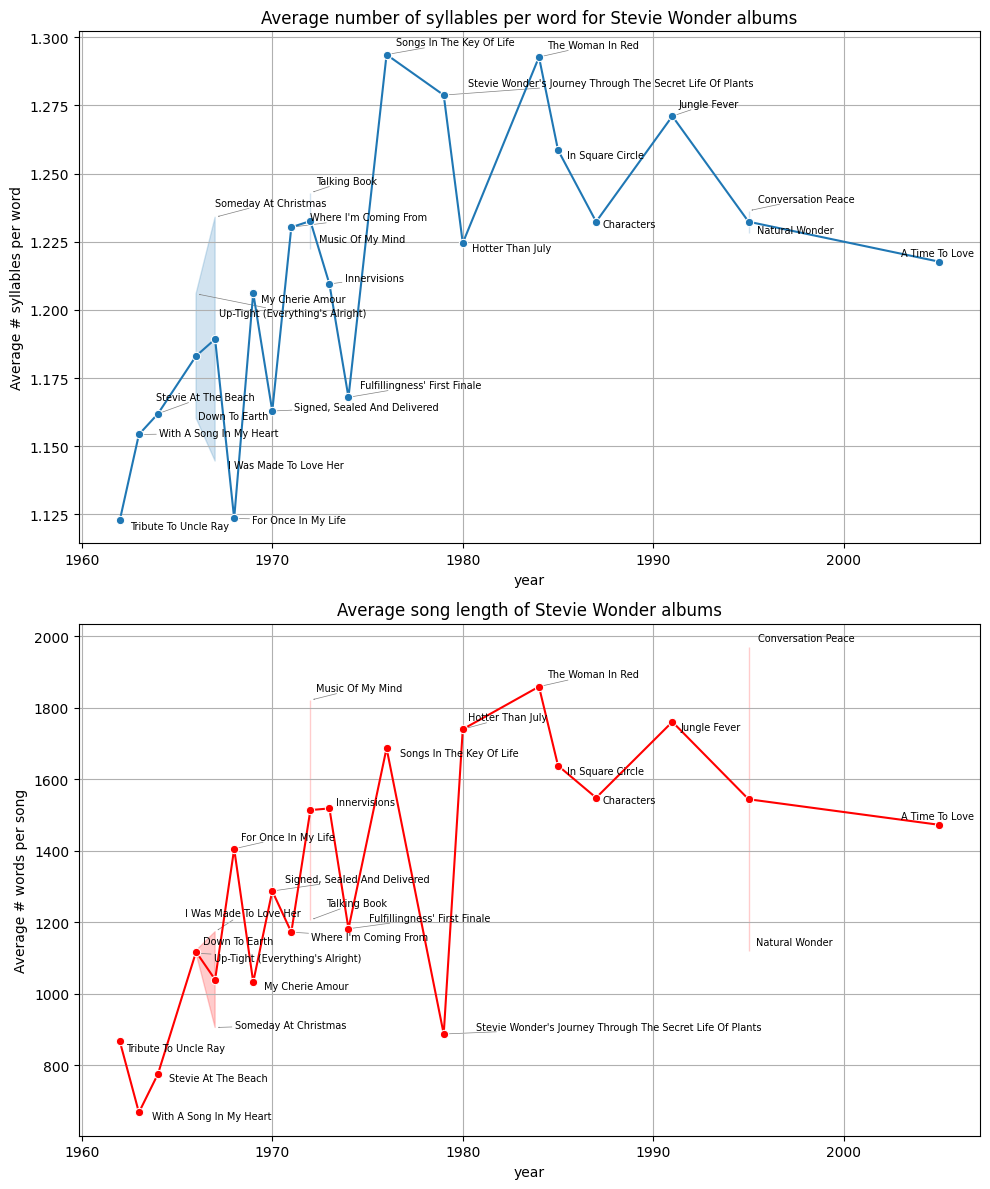

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is already cleaned and processed
df = pd.read_json("steviewonder_songs.json")
df = basic_clean(df)
syll_and_len_plot(df, "Stevie Wonder")


Stevie's data shows a very clear overarching story in his career. The increase in both graphs, leading ultimately to a plateau, is clearly visible and explainable by his musical history. In Stevie Wonder’s early Motown era, while he was still a child, his lyrics were straightforward and conversational, reflecting the pop style of his Motown label. Songs were concise and catchy, designed for mass appeal.

During Stevie’s classic period, his songwriting slowly increased and ultimately reached its peak in both complexity and length (both graphs). His most acclaimed albums, such as Talking Book, Innervisions, and Songs in the Key of Life, were introspective, often featuring extended verses and vivid imagery, making them feel more like musical journeys than traditional pop songs. Many dealt with social justice and spirituality (“Living for the City,” “As”).

In the 1980s and beyond, Stevie leaned into a more commercially oriented sound. There's less of a trend evident in the data, although we can see that there's less experimentation (i.e. variation in both metrics) and simply less output in general (i.e. points are more spaced out), with both metrics staying pretty high.

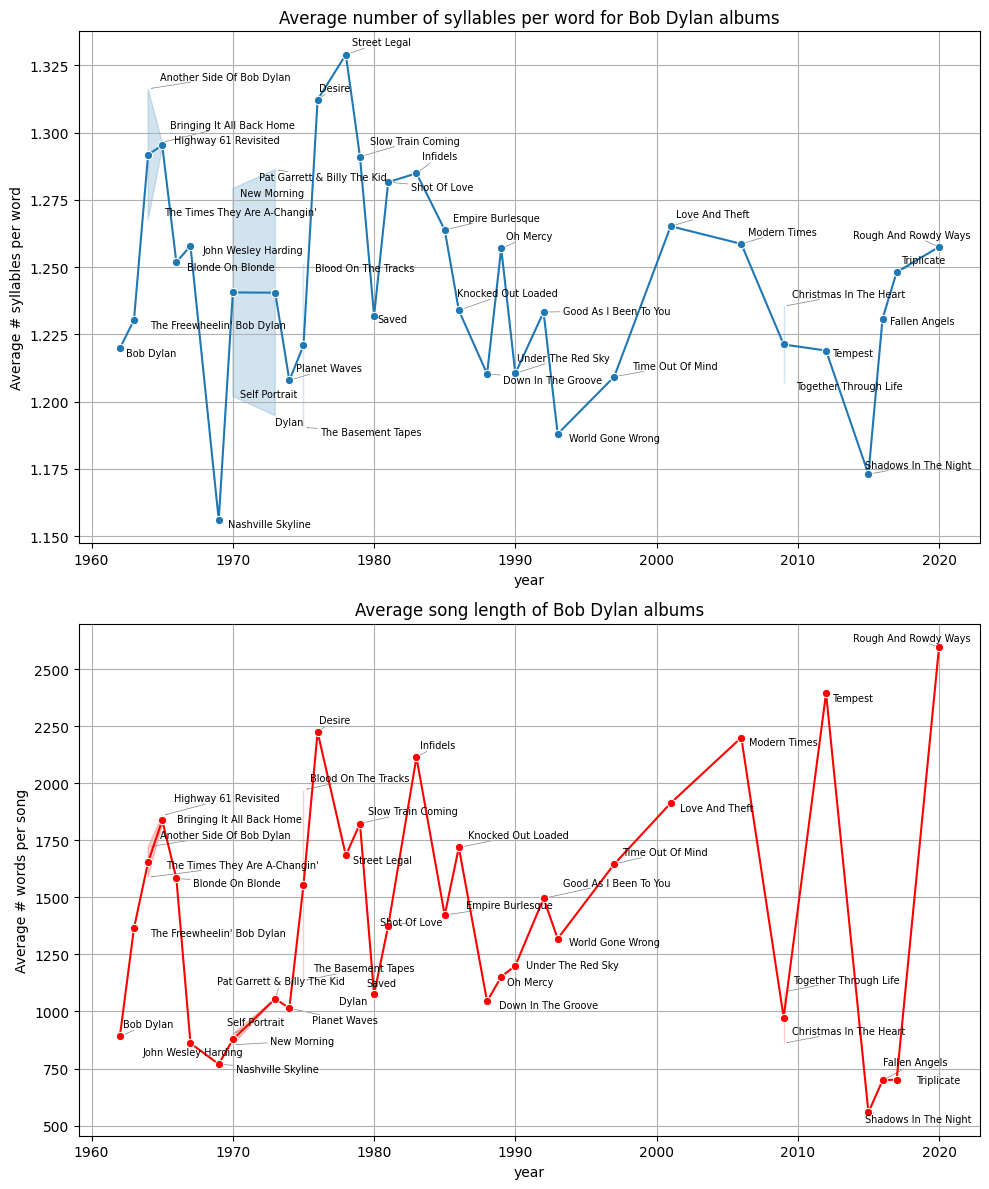

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is already cleaned and processed
df = pd.read_json("bobdylan_songs.json")
df = basic_clean(df)
syll_and_len_plot(df, "Bob Dylan")

Dylan is an artist for which this data simply is not very interpretable. It's difficult to pick out trends in his long and storied career, featuring flip-flops between genres.

One trend we can pick out is the peak and dip in the first five years of both graphs. In Dylan’s early 1960s period, he wrote folk songs with simple, direct language; as he transitioned into his mid-1960s electric phase, his lyrics became more surreal and poetic and increased rapidly in both lyrics/word and words/song. Highway 61 Revisited and Blonde on Blonde -- among his most acclaimed -- were known for their dense, stream-of-consciousness stories. Soon after, he suffered a motorcycle accident and returned back to a style of introspection and simplicity, reaching a minimum on both metrics on the simplistic country-based Nashville Skyline.

Dylan's output after this becomes very uneven and difficult to account for, with sharp spikes without any clear trend. Suddenly, though, we can see a clean linear increase in song length from the late 80s to the late 2000s. During this time, Dylan shifted from an uneven period in his writing to a period of renewed lyrical energy, slowly returning to the ambition of his early work with wry humor and existential musings. 

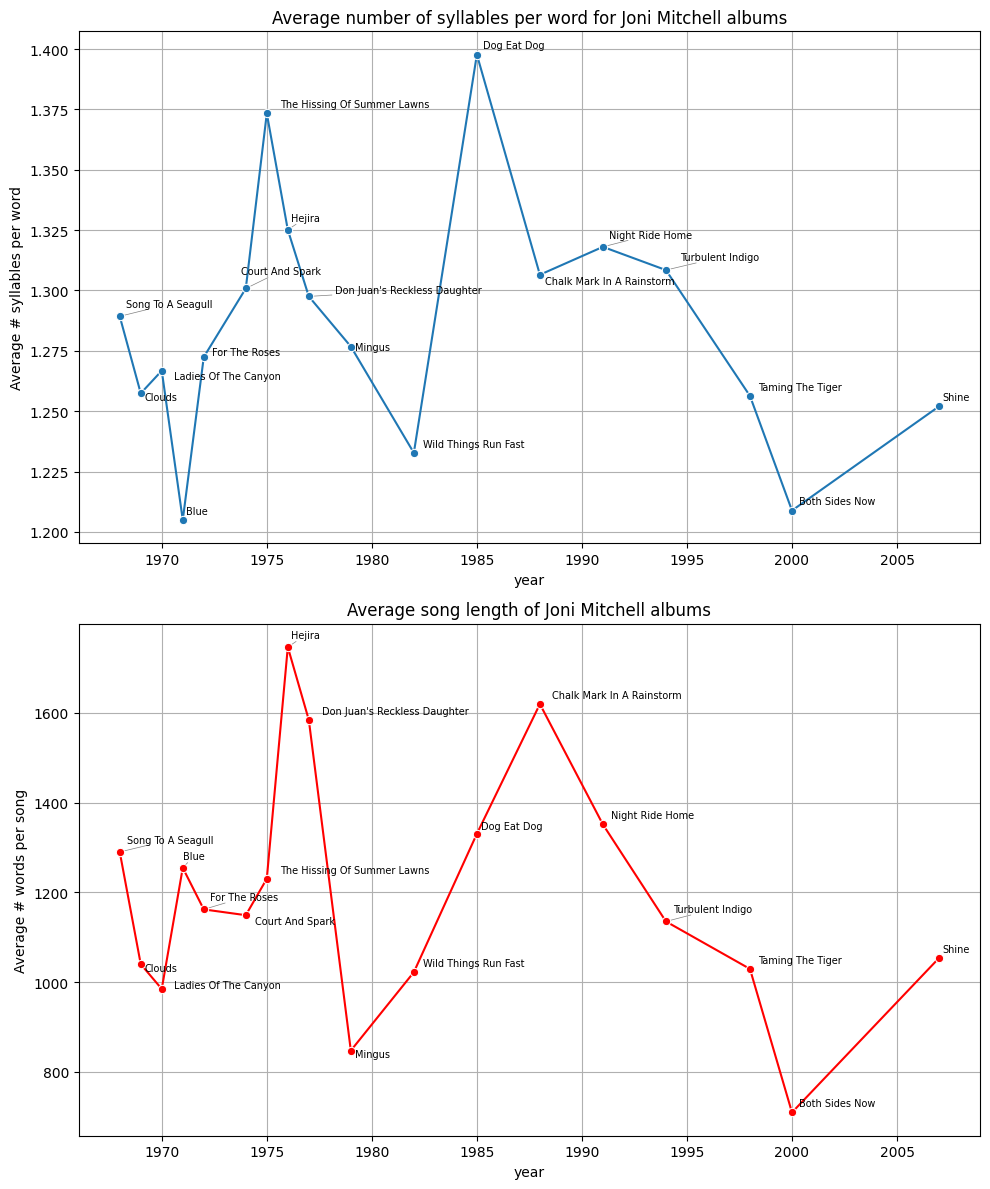

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is already cleaned and processed
df = pd.read_json("jonimitchell_songs.json")
df = basic_clean(df)
syll_and_len_plot(df, "Joni Mitchell")

Joni Mitchell’s, Dylan's contemporary, also lived a storied life and career with many twists and turns, providing a graph which is somewhat difficult to interpret.

Both graphs begin low: in her early folk era, Joni's songwriting was intimate and stripped-down, with songs like “Both Sides Now” capturing themes of love and self-discovery through simple, short series of images. Blue was Joni's most intimate and confessional album, with emotional content reaching a peak even as linguistic complexity reached a minimum.

In the mid-70s to the mid-80s, we can see large spikes and dips in the graph as Joni’s lyrics became abstract and experimental. Some lyrics were expansive and philosophical as she shifted toward jazz and avant-garde styles. Hejira makes sense as a peak in song length with long winding narratives like "Song for Sharon."

In her later career, from the 1980s onward, Joni’s lyrics became more reflective and observational, pondering love, aging, and society with a more grounded tone. We can see both metrics steadily declining in recent years as Joni's style mellows.

In [28]:
# word freq table (unused)
def word_freq(df):
    # Initialize CountVectorizer with stop words removal
    vectorizer = CountVectorizer(stop_words='english')

    # Fit and transform the lyrics
    X = vectorizer.fit_transform(df['lyrics'])

    # Get the feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Get the summed counts for each word
    word_counts = X.toarray().sum(axis=0)

    # Create a DataFrame for better visualization
    word_freq = pd.DataFrame({'word': feature_names, 'count': word_counts})
    word_freq = word_freq.sort_values(by='count', ascending=False)

    # Display the top words
    print("Word Frequencies:")
    print(word_freq.head(10))

# Takeaways

What are some overarching takeways we can gain from observing the data for these five artists? 

One clear pattern I picked up on is that sometimes, a maximum or a minimum in the metrics is when a artist makes their best work; sometimes, that's exactly when an artist makes their worst work. However, it's rare that an artist makes their best or worst work in middle of an incline or decline in the metrics. Blue is famous for its intimate simplicity, reflected by a minimum in both metrics; on the other hand, Dog Eat Dog is an awful jumble of complicated nonsense, with a maximum in syllables/word. Songs in the Key of Life is famous for its ambition, reflected by a maximum in both metrics; Reputation also hit a maximum in song length but was one of Taylor's most disliked albums. This reflects a key truth in the artistic process: artists perform best (and worst) when they push themselves, or are pushed by external events (see the context essay for examples), to extremes, causing them to revolutionize and innovate. But these extremes don't come out of nowhere -- we can usually see a trend or an incline or decline, where an artist is slowly honing their ideas and metamorphisizing over the course of several albums, before they make their magnum opus.

Another commonality between the graphs is that they begin relatively flat or linear. Artists don't start their careers in an experimental mindset, playing with narrative length and linguistic complexity off the bat. They begin with one particular style, slowly gravitating away from it, until they gain enough comfort, legroom, and perhaps boredom, to make bold changes. This is why we see the biggest spikes and gaps between data points in the middle and ends of the graphs. 

# Reflection

This project showed me both the potential and limitations of current NLP technology. While my project didn't ultimately turn out quite as sophisticated as I had pictured, these simple metrics are still able to tell us a lot about the career arcs of songwriters, both on an individual level and in general. The graphs are expressive and interpretable, even to a layman, and provide a very interesting object of analysis.

There are many potential extensions to the project to explore in the future. One idea is looking at groups of singers (i.e. One Direction) and the directions each of their members went in when the group disbanded. Another idea is actually scraping critical review data (i.e. how many stars did this album recieve) and calculating correlation with each of the lyrics-based metrics. Finally, with the advent of large language models, NLP technology may improve enough that topic modeling and sentiment analysis will be feasible methods for this kind of project in the near future.